In [1]:
from keras.layers import Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.models import Sequential, Model, model_from_json

from keras.layers import Conv1D, Dense, MaxPooling1D, UpSampling1D
from keras.models import Model, Sequential

Text(0, 0.5, 'Label')

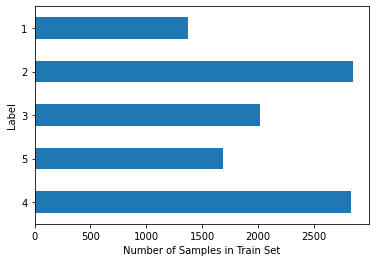

In [2]:
data = pd.read_csv("../dataset/sst5/sst5.csv")
ax = data['truth'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in Train Set")
ax.set_ylabel("Label")

In [3]:
import numpy as np
df = pd.read_csv("../dataset/sst5/sst5.csv")
labels = np.array(df['truth'])
texts = np.array(df['text'])

In [4]:
#标签和text输入转换成列表处理
labels_list = labels.tolist()
texts_list = texts.tolist()


In [5]:
#得到文本中的所有字母
seen_chars = set()
for line in texts_list: 
    for c in line:
        seen_chars.add(c)

In [6]:
# Establish character mapping to index and its reverse
char_to_index = dict(zip(seen_chars, range(0, len(seen_chars))))
index_to_char = {i: c for c, i in char_to_index.items()}
num_chars = len(char_to_index)
#set maximum sentence length to 268，easy to reduce dimensionality
max_len = 268

num_lines = len(texts_list)
# One-hot encode the input
one_hot = np.zeros([num_lines, max_len, num_chars])
for i in range(0, num_lines):
    line = texts_list[i]
    line_len = len(line)
    for j in range(0, line_len):
        one_hot[i, j, char_to_index.get(line[j])] = 1
    for j in range(line_len, max_len):
        one_hot[i, j, char_to_index.get(' ')] = 1
one_hot.shape

(10754, 268, 95)

In [7]:
labels_array = np.array(labels_list)
X_train, X_test, y_train, y_test = train_test_split( one_hot, labels_array, test_size=0.2, random_state=42)
X_train.shape
y_train.shape
y_train = y_train.reshape(8603,1)

In [8]:
X_train.shape

(8603, 268, 95)

In [9]:
max_len = 268
embedding_dim = 32
num_filters_1 = 32
num_filters_2 = 24
kernel_size = 3
pool_size = 2

In [10]:

model = Sequential()


model.add(Dense(name='embedding',
                input_shape=(max_len, num_chars),
                units=embedding_dim,
                activation=None))

model.add(Conv1D(name='encoder_conv_1',
                    filters=num_filters_1,
                    kernel_size=kernel_size,
                    padding='same',
                    activation='relu'))
model.add(MaxPooling1D(name='encoder_pool_1',
                        pool_size=pool_size))

model.add(Conv1D(name='encoder_conv_2',
                    filters=num_filters_2,
                    kernel_size=kernel_size,
                    padding='same',
                    activation='relu'))
#text embedding
model.add(MaxPooling1D(name='encoded',
                        pool_size=pool_size))


model.add(UpSampling1D(name='decoder_unpool_2',
                        size=pool_size))
model.add(Conv1D(name='decoder_conv_2',
                    filters=num_filters_2,
                    kernel_size=kernel_size,
                    padding='same',
                    activation='relu'))

model.add(UpSampling1D(name='decoder_unpool_1',
                        size=pool_size))
model.add(Conv1D(name='decoder_conv_1',
                    filters=num_filters_1,
                    kernel_size=kernel_size,
                    padding='same',
                    activation='relu'))

model.add(Dense(name='unembedding',
                units=num_chars,
                activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Dense)           (None, 268, 32)           3072      
                                                                 
 encoder_conv_1 (Conv1D)     (None, 268, 32)           3104      
                                                                 
 encoder_pool_1 (MaxPooling1  (None, 134, 32)          0         
 D)                                                              
                                                                 
 encoder_conv_2 (Conv1D)     (None, 134, 24)           2328      
                                                                 
 encoded (MaxPooling1D)      (None, 67, 24)            0         
                                                                 
 decoder_unpool_2 (UpSamplin  (None, 134, 24)          0         
 g1D)                                                   

2022-05-11 18:22:05.715064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:22:05.716509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:22:05.724339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-05-11 18:22:05.725158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-11 18:22:05.725176: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU 

In [11]:
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]
model_history = model.fit(X_train, X_train,
          epochs=100,
          batch_size=64,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, X_test),callbacks=callbacks)

2022-05-11 18:15:00.547777: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 876129520 exceeds 10% of free system memory.


Epoch 1/100


2022-05-11 18:15:03.575699: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 876129520 exceeds 10% of free system memory.


133/135 [============================>.] - ETA: 0s - loss: 1.4033 - acc: 0.6916

2022-05-11 18:15:07.664915: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219057840 exceeds 10% of free system memory.
2022-05-11 18:15:07.773479: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219057840 exceeds 10% of free system memory.


135/135 [==============================] - 4s 25ms/step - loss: 1.4013 - acc: 0.6913 - val_loss: 1.1279 - val_acc: 0.6896 - lr: 0.0010
Epoch 2/100
135/135 [==============================] - 3s 22ms/step - loss: 1.0274 - acc: 0.7099 - val_loss: 0.9712 - val_acc: 0.7159 - lr: 0.0010
Epoch 3/100
135/135 [==============================] - 3s 23ms/step - loss: 0.9047 - acc: 0.7317 - val_loss: 0.8703 - val_acc: 0.7358 - lr: 0.0010
Epoch 4/100
135/135 [==============================] - 3s 22ms/step - loss: 0.8156 - acc: 0.7485 - val_loss: 0.7967 - val_acc: 0.7494 - lr: 0.0010
Epoch 5/100
135/135 [==============================] - 3s 22ms/step - loss: 0.7489 - acc: 0.7614 - val_loss: 0.7428 - val_acc: 0.7591 - lr: 0.0010
Epoch 6/100
135/135 [==============================] - 3s 22ms/step - loss: 0.7024 - acc: 0.7708 - val_loss: 0.7046 - val_acc: 0.7679 - lr: 0.0010
Epoch 7/100
135/135 [==============================] - 3s 22ms/step - loss: 0.6656 - acc: 0.7788 - val_loss: 0.6629 - val_acc: 0.7

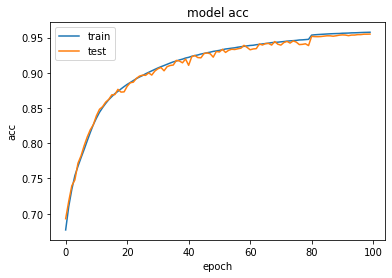

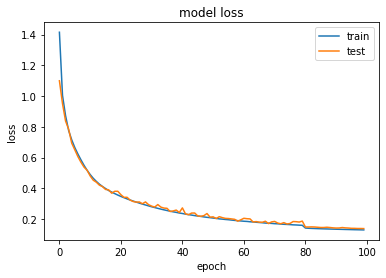

In [59]:
from plot import get_results
labels = ['1','2','3','4','5']
lb = None
results = get_results(model_history,model,X_test,y_test, labels,lb)
results.create_plot_acc(model_history)
results.create_plot_loss(model_history)

In [60]:
# Save model and weights
model_name = 'model_text_auto_encoder.h5'
save_dir = "./model/"

model_path = save_dir + model_name
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("./model/model_json_text_auto_encoder.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at ./model/model_text_auto_encoder.h5 


In [61]:
# loading json and model architecture 
json_file = open('./model/model_json_text_auto_encoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./model/model_text_auto_encoder.h5")
print("Loaded model from disk")

Loaded model from disk


In [62]:
encoded_layer_model = Model(inputs=loaded_model.input,
                                     outputs=loaded_model.get_layer('encoded').output)
#output the prediction result of model
encoded_output = encoded_layer_model.predict(X_train)
encoded_output.shape

(8603, 67, 24)

In [63]:
temp = encoded_output.reshape(encoded_output.shape[0], encoded_output.shape[1]*encoded_output.shape[2])
print(temp.shape)
print(y_train.shape)

(8603, 1608)
(8603, 1)


In [64]:
em_df = pd.DataFrame(temp)
em_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607
0,5.354230,3.535457,7.348618,4.718048,7.335632,6.937083,3.644210,4.429690,4.881655,2.209894,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
1,6.343656,3.772492,6.890505,6.539682,6.515871,3.221131,2.128765,3.987325,1.806336,5.799919,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
2,8.652696,4.187095,3.165394,2.999269,6.707338,1.457551,0.000000,4.810442,1.611260,6.024842,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
3,3.549071,6.404244,7.015340,4.225493,4.072373,5.748169,6.250419,7.483934,4.623145,3.759971,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
4,2.842956,3.263400,7.103064,4.562712,6.050471,7.587608,3.260895,6.198865,4.598395,5.113907,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0


In [65]:
label_df = pd.DataFrame(y_train)
label_df.head()

,0
0,5
1,2
2,4
3,5
4,5


In [66]:
em_out_df = pd.concat([label_df, em_df], axis = 1)
em_out_df.head()

,0,0,1,2,3,4,5,6,7,8,...,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607
0,5,5.354230,3.535457,7.348618,4.718048,7.335632,6.937083,3.644210,4.429690,4.881655,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
1,2,6.343656,3.772492,6.890505,6.539682,6.515871,3.221131,2.128765,3.987325,1.806336,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
2,4,8.652696,4.187095,3.165394,2.999269,6.707338,1.457551,0.000000,4.810442,1.611260,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
3,5,3.549071,6.404244,7.015340,4.225493,4.072373,5.748169,6.250419,7.483934,4.623145,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
4,5,2.842956,3.263400,7.103064,4.562712,6.050471,7.587608,3.260895,6.198865,4.598395,...,1.994431,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0


In [67]:
em_out_df.to_csv("../dataset/text_embedding.csv",index=False)
em_out_df = pd.read_csv("../dataset/text_embedding.csv")

In [50]:
em_out_df.head()

,0,0.1,1,2,3,4,5,6,7,8,...,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607
0,5,2.254337,5.165623,4.170316,6.147706,3.916476,2.296392,1.982314,3.607228,4.037129,...,1.559086,0.0,1.656902,1.336881,0.289147,5.451889,2.243525,1.560793,1.997813,4.375338
1,2,3.155878,5.106555,2.040560,4.134066,4.166143,3.136068,2.588916,1.364512,3.930419,...,1.559086,0.0,1.656902,1.336881,0.289147,5.451889,2.243525,1.560793,1.997813,4.375338
2,4,4.707554,1.825697,4.369482,1.393705,4.203702,2.040582,1.442356,1.945554,5.687757,...,1.559086,0.0,1.656902,1.336881,0.289147,5.451889,2.243525,1.560793,1.997813,4.375338
3,5,3.098471,3.829592,3.278016,2.361093,1.881340,4.748493,3.016437,6.874717,5.752899,...,1.559086,0.0,1.656902,1.336881,0.289147,5.451889,2.243525,1.560793,1.997813,4.375338
4,5,1.360425,4.903392,0.838347,7.883596,3.796540,7.993061,3.101933,5.225678,1.921025,...,1.559086,0.0,1.656902,1.336881,0.289147,5.451889,2.243525,1.560793,1.997813,4.375338


In [68]:
import random
lines_to_predict = 5
# Round-trip encode-decode some lines
#first_line = random.randrange(0, len(one_hot) - lines_to_predict)

first_line = 0
predict_range = range(first_line, first_line + lines_to_predict)
print(predict_range)
one_hot_to_predict = one_hot[predict_range]
one_hot_to_predict.shape

range(0, 5)


(5, 268, 95)

In [69]:
predicted = model.predict(one_hot_to_predict)
predicted.shape

(5, 268, 95)

In [70]:
# Examine the activations in the first encoder convolutional layer
activation_model = Model(inputs=[model.input],
                         outputs=[model.layers[1].output, model.layers[3].output])
(activations_1, activations_2) = activation_model.predict(one_hot_to_predict)

In [71]:
# Find scale of activations
min_act_1 = np.min(activations_1)
act_range_1 = np.max(activations_1) - min_act_1
min_act_2 = np.min(activations_2)
act_range_2 = np.max(activations_2) - min_act_2

In [72]:
def print_activation(letter, act, minact, actrange):
    max_lum = 240
    lum = max_lum - int(max_lum * (act - minact) / actrange)
    return '''<span style="color:rgb({},{},{})">{}</span>'''.format(lum, lum, lum, letter)

def print_activation_2(l, i, n, line):
    return print_activation(line[i], activations_2[l, i // pool_size, n], min_act_2, act_range_2)

In [73]:
# Show second conv layer activations
from IPython.display import display, HTML
for n in range(0, num_filters_2):
    print('Filter {}:'.format(n))
    for l in predict_range:
        line = texts_list[l]
        marked_up_letters = ''.join(map(lambda i: print_activation_2(l - first_line, i, n, line), range(0, len(line))))
        display(HTML('''<span style="font-family:monospace">''' + marked_up_letters + '''</span>'''))
    print()

# Print round-trip unencoded text as a sanity check

for p in one_hot_to_predict:
    print(''.join(map(lambda a: index_to_char.get(a), np.argmax(p, axis=1))))

for p in predicted:
    print(''.join(map(lambda a: index_to_char.get(a), np.argmax(p, axis=1))))

Filter 0:



Filter 1:



Filter 2:



Filter 3:



Filter 4:



Filter 5:



Filter 6:



Filter 7:



Filter 8:



Filter 9:



Filter 10:



Filter 11:



Filter 12:



Filter 13:



Filter 14:



Filter 15:



Filter 16:



Filter 17:



Filter 18:



Filter 19:



Filter 20:



Filter 21:



Filter 22:



Filter 23:



原文五句话：
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .                                                                                       
The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .                                          
Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .                                                            
You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .                                                                                     